### DGRP panel example
    Script illustrating genomic selection with thinned DGRP data


In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
import os
import copy

# SeqBreed modules
from SeqBreed import genome as gg
from SeqBreed.selection import selection as sel

############ main #################
# current dir
cdir = os.getcwd()

# working directory
wdir = cdir

# input file dir
ddir= wdir

# input files
chipfiles = [ ] # can include sequence as output from read_vcf
mapfile = ddir+'/dgrp.map' # note males do not recombine
vcffile = ddir+'/dgrp.vcf.gz'

# goto working directory
os.chdir(wdir)

# working files
seqfile = 'seq.pos'
gpickfile = 'gfounder.p'

ploidy: 2
N base: 205
N snps: 21926
GENOME FEATURES (ploidy = 2)
Chr  Type   bplength    Nsnps length_m length_f
1  Autos  22421723 4075 [0.0005037700000000001, 0.11399490762401611]
2  Autos  44656356 8146 [0.00035314, 0.23686204910112277]
3  Autos  56005338 9705 [0.00224157, 0.2782845192991159]
All        123083417  21926 [0.00309848 0.62914148]

QTN file  does not exist or not specified!
QTN effects and positions randomly sampled
#h2 by trait 0.5
#se undefined
1 1688692 0.005 2.3132707147081484 0 0.051952369565895294 0.0
1 2702033 0.005 0.00046589297953658474 0 2.1072922664995227e-09 0.0
1 5678269 0.005 0.00034133369360681134 0 1.131125417718919e-09 0.0
1 11884610 0.020 0.7516134368574021 0 0.02161560489258942 0.0
1 12433260 0.015 0.03252721281142268 0 3.0513259317426548e-05 0.0
1 20149961 0.302 0.6017025943159573 0 0.15276144877811318 0.0
2 3743819 0.029 5.519196097129607 0 1.7309249978314525 0.0
2 4293935 0.029 -0.00020508353756057844 0 2.38994661795423e-09 0.0
2 11225708 0.015 0.1

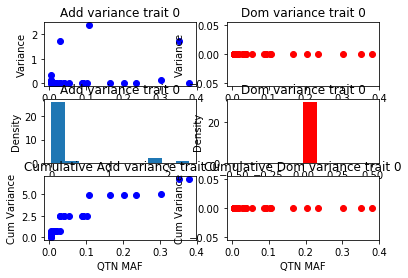

No. of individuals is 205


In [7]:
# Reading vcf file
gbase = gg.GFounder(vcfFile=vcffile, snpFile=seqfile)

# generates genome object with chr names, recombination map, etc
# requires snpFile generated in previous step, this file simply stores snp positions
gfeatures = gg.Genome(snpFile=seqfile, mapFile=mapfile, ploidy=gbase.ploidy)
# prints some basic info
gfeatures.print()

# 20 QTNs are randomly positioned along the genome
qtn = gg.QTNs(h2=[.5], genome=gfeatures, nqtn=30, qtnFile=None)
# get add and dom variance per locus, assuming equilibrium
qtn.get_var(gfeatures, gbase)

# print and plot main qtn features
qtn.print(gfeatures)
qtn.plot()

# chipfiles contains list of chips, sequence is an additional chip
chipfiles.append(seqfile)
# add chip information
chips = []
for file in chipfiles:
    chip = gg.Chip(chipFile=file, genome=gfeatures, name=file+'_chip')
    chips.append(chip)

# generate individual genomes through pedigree, it also computes se
# CHANGE TO INIT WITH NBASE > GBASE.NBASE, THEN INIT QTL , SET GVALUES AND Y FOR FOUNDER INDIVIDUALS
pop = gg.Population(gfeatures, pedFile=None, generation=None, qtns=qtn, gfounders=gbase)
print('No. of individuals is '+str(len(pop.inds)))

In [8]:
# SELECTION is implemented in cycles.
# Initializes and saves base populations
pop0 = copy.deepcopy(pop)

# no. of males and females selected, here 5 & 10
nsel = [5, 10] 
# no. of offspring per female, thus 100 individuals per generation
noffspring = 10

# no. of generations of selection
ngen = 3

# PHENOTYPIC SELECTION, discrete generations, random mating
print('\nMass selection, discrete generations, assortative mating')
# init population
pop = copy.deepcopy(pop0)
for t in range(ngen):
    print('  Generation, N: ' + str(t) + ' ' + str(len(pop.inds)))
    # step 1: do evaluation, adds ebv to pop.inds[:].ebv
    sel.doEbv(pop, criterion='phenotype')
    # step 2: pedigree with offspring of selected individuals, discrete generations
    newPed = sel.ReturnNewPed(pop, nsel, famsize=noffspring, mating='assortative',  generation=t)
    # step 3: generates new offspring (this function adds QTN genotypes, true bvs and y)
    pop.addPed(newPed, gfeatures, qtn, gbase)
print('No. of individuals is ' + str(len(pop.inds)))


Mass selection, discrete generations, assortative mating
  Generation, N: 0 205
  Generation, N: 1 305
  Generation, N: 2 405
No. of individuals is 505


In [9]:
# GBLUP USING SEQUENCE chip[0], SNPs MAF > 0.05, continuous generation
print('\n'+'GBLUP selection, continuous generations, random mating')
# init population
pop = copy.deepcopy(pop0)
for t in range(ngen):
    print('generation ' + str(t) + ' ' + str(len(pop.inds)))
    # step 0: generate marker data for evaluation
    X = gg.do_X(pop.inds, gfeatures, gbase, chips[0], minMaf=0.05)
    # step 1: predicts breeding values
    sel.doEbv(pop, criterion='gblup', X=X, h2=0.3, nh=gfeatures.ploidy)
    # step 2: pedigree with offspring of selected individuals
    newPed = sel.ReturnNewPed(pop, nsel, famsize=noffspring, mating='random',  generation=0)
    # step 3: generates new offspring (this function adds QTN genotypes, true bvs and y)
    pop.addPed(newPed, gfeatures, qtn, gbase)
print('No. of individuals is ' + str(len(pop.inds)))
pop.print()


GBLUP selection, continuous generations, random mating
generation 0 205
generation 1 305
generation 2 405
No. of individuals is 505
#ID FATHER MOTHER SEX GENERATION Y_0 ADD_0 GEN_0 EBV 
1 0 0 0 0 -6.847025890814115 -9.024427729084582 -9.024427729084582 -0.9545395249388546
2 0 0 1 0 7.059573433876305 1.921270706281705 1.921270706281705 12.940844570240493
3 0 0 1 0 6.021290236257726 5.976539488746015 5.976539488746015 11.913015238727226
4 0 0 0 0 -7.52197151540417 -5.113982944401219 -5.113982944401219 -1.6273098394729768
5 0 0 0 0 -5.076329610474001 -3.8585068428736147 -3.8585068428736147 0.8181363274442462
6 0 0 1 0 -2.1376650022797823 -5.06191203150553 -5.06191203150553 3.7560209289203215
7 0 0 0 0 -10.21914954097556 -9.02491768861768 -9.02491768861768 -4.323954153073495
8 0 0 0 0 0.4619037861550792 -3.910929676901606 -3.910929676901606 6.354867128141229
9 0 0 1 0 -7.945486946499484 -5.1134929848681185 -5.1134929848681185 -2.0510422981711036
10 0 0 0 0 -8.206453832886464 -9.0169985581

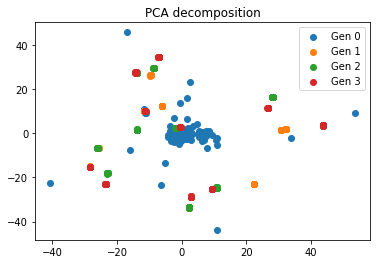

In [11]:
# PCA plot with individuals colored by generation
X = gg.do_X(pop.inds, gfeatures, gbase, chips[0], minMaf=1e-2)
pca = sel.Pca(X)
pca.fit()
pca.plot(labels=pop.t)